In [ ]:
!git clone https://github.com/sinbaramDL/dacon-credit-card-defaults-detection

fatal: destination path 'dacon-credit-card-defaults-detection' already exists and is not an empty directory.


In [ ]:
cd /content/dacon-credit-card-defaults-detection

/content/dacon-credit-card-defaults-detection


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

# 한글 사용 설정 
plt.rcParams['axes.unicode_minus'] = False

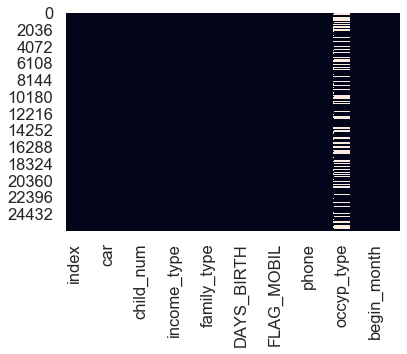

In [3]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")
sns.heatmap(train.isnull(), cbar=False)

In [4]:
train = train.drop(["occyp_type","index"], axis = 1)
test =  test.drop(["occyp_type","index"], axis = 1)
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  family_size    26457 non-null  float64
 16  begin_month    26457 non-null  float64
 17  credit         26457 non-null  float64
dtypes: flo

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,2.0,-26.0,2.0


In [5]:
unique_len = train.apply(lambda x : len(x.unique()))
group_1, group_2 = unique_len[unique_len <= 10].index, unique_len[unique_len > 10].index
print(group_1.shape, group_2.shape)

(14,) (4,)


In [6]:
def plot_nominal(header, ax):
  uniq = np.sort(train[header].unique())
  x_axis = np.arange(len(uniq))
  ax.set_xticks(x_axis) 
  ax.set_xticklabels(uniq, fontsize=12)
  ax.set_title(header)
  credit_0 = train.loc[train['credit'] == 0.0]
  credit_1 = train.loc[train['credit'] == 1.0]
  credit_2 = train.loc[train['credit'] == 2.0]
  ax.bar(x_axis, [len(credit_0.loc[credit_0[header]==inst]) for inst in uniq], color='red', label='credit=0')
  ax.bar(x_axis, [len(credit_1.loc[credit_1[header]==inst]) for inst in uniq], color='blue', label='credit=1', bottom=[len(credit_0.loc[credit_0[header]==inst]) for inst in uniq])
  ax.bar(x_axis, [len(credit_2.loc[credit_2[header]==inst]) for inst in uniq], color='purple', label='credit=2', bottom=[len(credit_1.loc[credit_1[header]==inst]) for inst in uniq])
  
def plot_numeric(header, ax):
  uniq = train[header].unique()
  x_axis = np.arange(len(uniq))
  credit_0 = train.loc[train['credit'] == 0.0]
  credit_1 = train.loc[train['credit'] == 1.0]
  credit_2 = train.loc[train['credit'] == 2.0]
  ax.set_title(header)
  ax.bar(x_axis, [len(credit_0.loc[credit_0[header]==inst]) for inst in uniq], color='red', label='credit=0')
  ax.bar(x_axis, [len(credit_1.loc[credit_1[header]==inst]) for inst in uniq], color='blue', label='credit=1', bottom=[len(credit_0.loc[credit_0[header]==inst]) for inst in uniq])
  ax.bar(x_axis, [len(credit_2.loc[credit_2[header]==inst]) for inst in uniq], color='cyan', label='credit=2', bottom=[len(credit_1.loc[credit_1[header]==inst]) for inst in uniq])

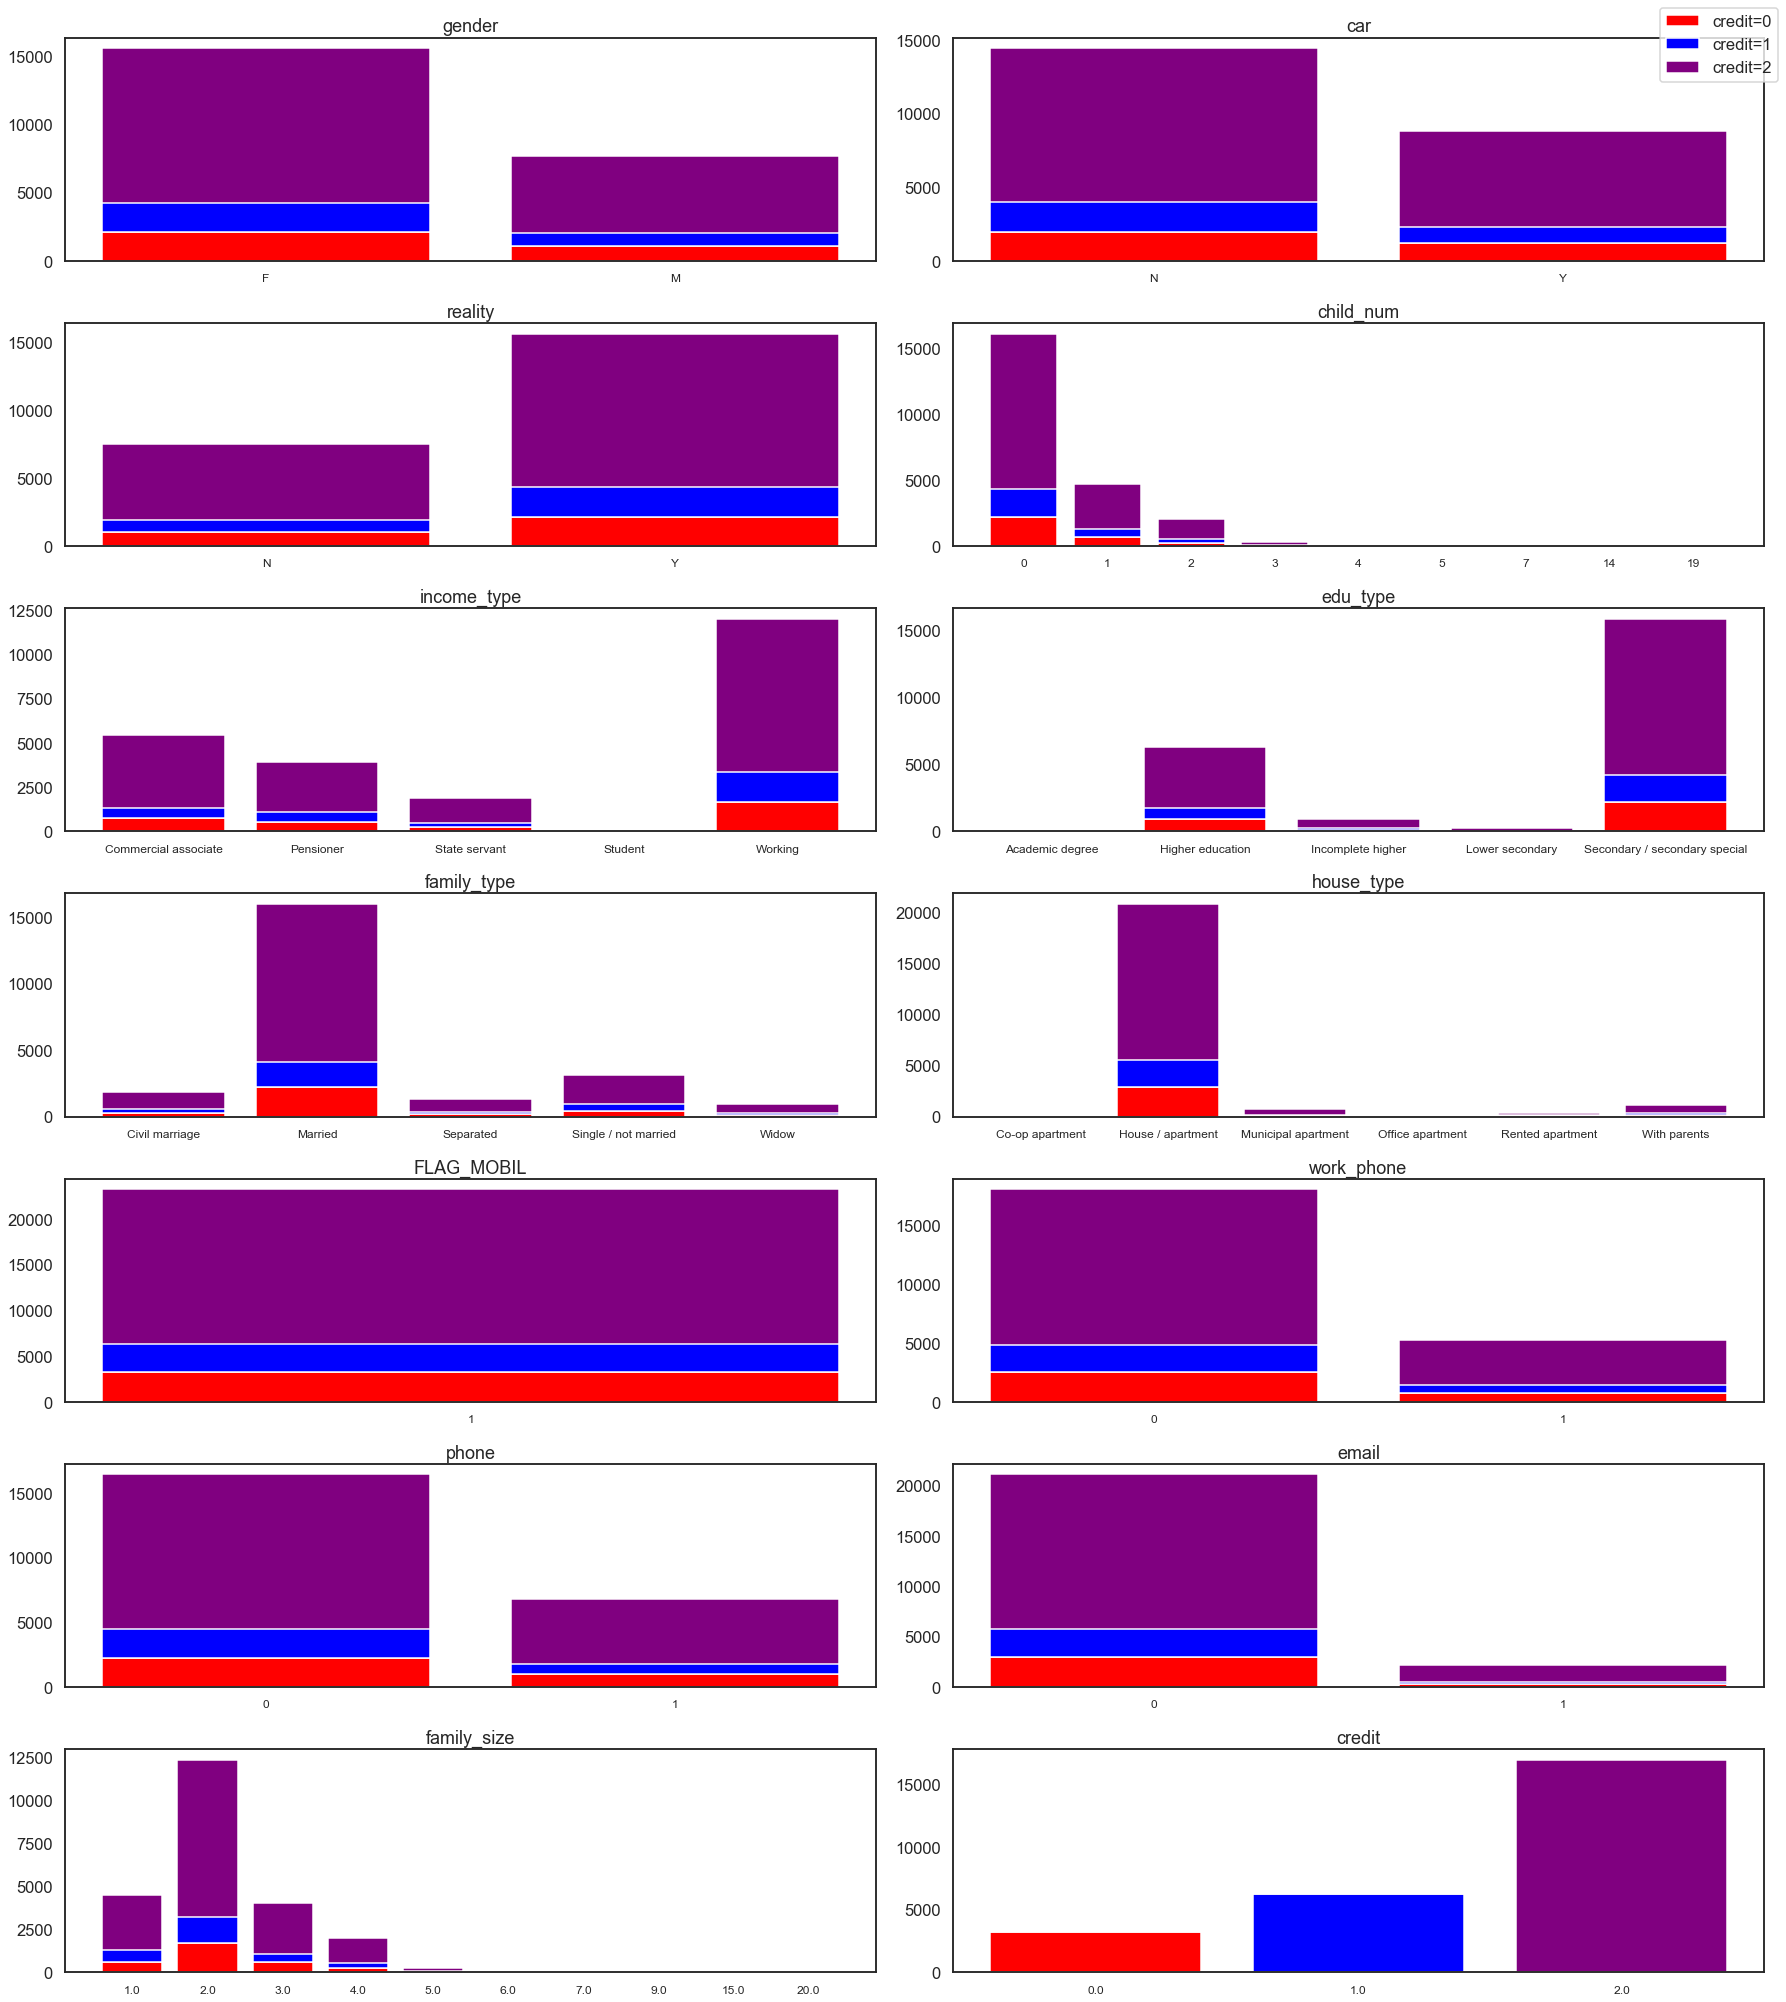

In [7]:
fig, axs = plt.subplots(7, 2)
fig.set_figwidth(25)
fig.set_figheight(28)
for i in range(7):
  for j in range(2):
    if (i * 2 + j < 14):
      plot_nominal(train[group_1].columns[i * 2 + j], axs[i][j])
handles, labels = axs[6][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.show()

In [108]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

def make_bin(header, n, negative=True):
    train[header]= -train[header] if negative else train[header]
    count, bin_dividers = np.histogram(train[header], bins=n) #train의 구간화를 적용
    print(bin_dividers)
    bin_names=[str(i) for i in range(n)]
    train[header]=pd.cut(x=train[header], bins=bin_dividers, labels=bin_names, include_lowest=True)
    train[header]=label_encoder.fit_transform(train[header])

make_bin('income_total', n=7, negative=False)
make_bin('DAYS_BIRTH', n=10)
make_bin('DAYS_EMPLOYED', n=6)
make_bin('begin_month', n=4)

[0.         0.85714286 1.71428571 2.57142857 3.42857143 4.28571429
 5.14285714 6.        ]
[-9.  -8.1 -7.2 -6.3 -5.4 -4.5 -3.6 -2.7 -1.8 -0.9  0. ]
[-1.         -0.83333333 -0.66666667 -0.5        -0.33333333 -0.16666667
  0.        ]
[-3.   -2.25 -1.5  -0.75  0.  ]


In [9]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,F,N,N,0,0,Commercial associate,Higher education,Married,Municipal apartment,3,1,1,0,0,0,2.0,0,1.0
1,F,N,Y,1,0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,2,1,1,0,0,1,3.0,0,1.0
2,M,Y,Y,0,1,Working,Higher education,Married,House / apartment,6,1,1,0,1,0,2.0,1,2.0
3,F,N,Y,0,0,Commercial associate,Secondary / secondary special,Married,House / apartment,4,1,1,0,1,0,2.0,2,0.0
4,F,Y,Y,0,0,State servant,Higher education,Married,House / apartment,4,1,1,0,0,0,2.0,1,2.0


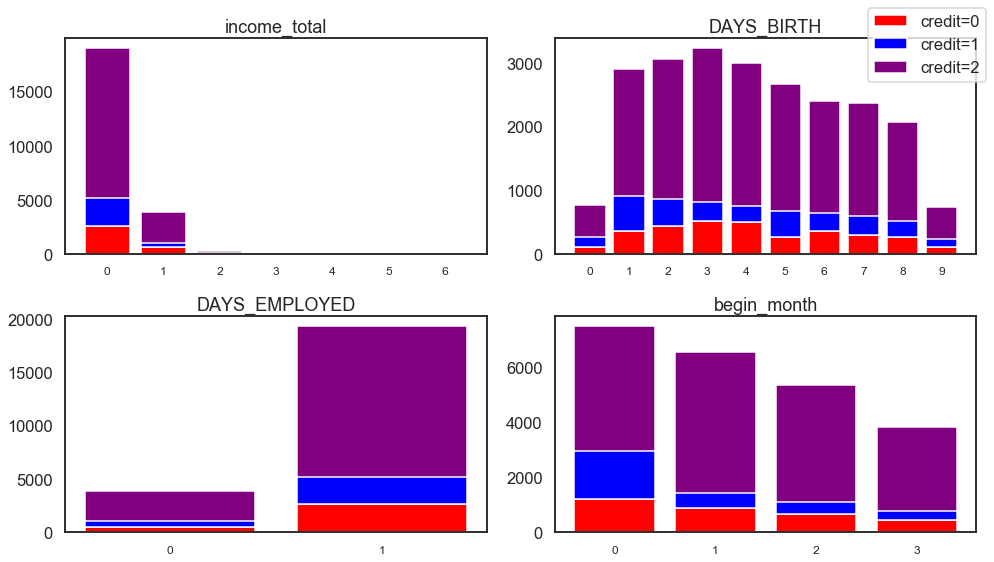

In [10]:
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(14)
fig.set_figheight(8)
for i in range(2):
  for j in range(2):
      plot_nominal(train[group_2].columns[i * 2 + j], axs[i][j])
handles, labels = axs[1][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.show()

# 윤우섭 시작점

In [3]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [5]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [28]:
train.head(10)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,F,N,N,0,0,Commercial associate,Higher education,Married,Municipal apartment,3,1,1,0,0,0,2.0,0,1.0
1,F,N,Y,1,0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,2,1,1,0,0,1,3.0,0,1.0
2,M,Y,Y,0,1,Working,Higher education,Married,House / apartment,6,1,1,0,1,0,2.0,1,2.0
3,F,N,Y,0,0,Commercial associate,Secondary / secondary special,Married,House / apartment,4,1,1,0,1,0,2.0,2,0.0
4,F,Y,Y,0,0,State servant,Higher education,Married,House / apartment,4,1,1,0,0,0,2.0,1,2.0
5,F,N,Y,2,1,Working,Secondary / secondary special,Married,House / apartment,3,1,1,0,0,1,4.0,1,1.0
6,F,N,N,0,1,Working,Secondary / secondary special,Separated,House / apartment,5,1,1,0,0,1,1.0,2,2.0
7,M,N,Y,0,1,Commercial associate,Secondary / secondary special,Married,House / apartment,4,1,1,0,0,1,2.0,3,0.0
8,M,Y,Y,1,0,Commercial associate,Higher education,Married,House / apartment,4,1,1,0,0,1,3.0,2,2.0
9,F,N,Y,0,0,Working,Secondary / secondary special,Married,House / apartment,4,1,1,0,0,0,2.0,0,2.0


In [11]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [25]:
def show_count_by_target(df, columns):
    cond_2 = (df['credit'] == 2)
    cond_1 = (df['credit'] == 1)
    cond_0 = (df['credit'] == 0)
    
    for column in columns:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), squeeze=False)
        # countplot을 이용하여 category값의 histogram 표현
        # x축의 tick label들이 값 유형이 많으므로 45도로 회전하여 표현
        chart0 = sns.countplot(df[cond_0][column], ax=axs[0][0])
        chart0.set_xticklabels(chart0.get_xticklabels(), rotation=45)
        chart1 = sns.countplot(df[cond_1][column], ax=axs[0][1])
        chart1.set_xticklabels(chart1.get_xticklabels(), rotation=45)
        chart2 = sns.countplot(df[cond_2][column], ax=axs[0][2])
        chart2.set_xticklabels(chart2.get_xticklabels(), rotation=45)        


In [103]:
def show_hist_by_target(df, columns):
    cond_2 = (df['credit'] == 2)
    cond_1 = (df['credit'] == 1)
    cond_0 = (df['credit'] == 0)
    
    for column in columns:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), squeeze=False) # 서브플랏 설정
        #sns.violinplot(x='credit', y=column, data=df, ax=axs[0][0] )
        sns.distplot(df[cond_0][column], ax=axs[0][0], label='0', color='blue',kde = False)
        sns.distplot(df[cond_1][column], ax=axs[0][1], label='1', color='red', kde = False)
        sns.distplot(df[cond_2][column], ax=axs[0][2], label='2', color='green', kde = False)

# 그냥 메모
* 딥러닝이니깐 아무래도 카테고리컬 데이터에 크게 영향을 받을 여지가 아무래도 큰 것 같음
* occyp_type활용하지 않았는데 활용이 필요해보임 --> 카테고리로 쓰기엔 종류가 많고 평균치로 연산필요

# 컬럼늘리기(engineering)
* 차량/부동산 --> 이거는 or연산 처리해서 구분하면 의미가 있을까 X
* 카테고리컬들은.. 바로위에서처럼 평균치 대체 시킨후에 사용할 수도 있을 것 같긴한데.. 너무 오버같긴한데다가, 만약에 교육수준 같은거면 숫자가 order가 있어야해서 가성비 안좋게 시간이 투자될 듯 함

# plot 특이사항
* childnum --> credit == 2에서 극단치 or 큰값이 있는 것으로 확인됨 극단치 제거 필요해보임
* income_total-- > 이것도 credit == 2에서 그냥 부자가 있는 것으로 보임 극단치 제거 필요해보임
* Day_birth --> 신용 0이 가장낮은 것 같은데, 나이대 구간대 별로 평균신용치도 가공해보는 게 좋을 것 같음. 신용0에서 중간나이대가 푹꺼지긴 하지만.. 활용할 방안은 잘.. 음.. 나이대마다 비중 특성이 있으니깐 그자체가 의미가 있는 것 같음 
* --> 20대부터 시작인 것으로 아는데.. 음.. 신용1이 젊은 친구비중이 높음

* Days_Employed --> 뭔가 이상함 재 가공해야함 0,1이런식으로 가공되면 안댈텐데 잘못댄듯
* begin_month --> 그냥 카테고리화만 해도 의미가 충분히 반영될 것 같긴한데, 그냥 평균신용치 가공해보는 것도 좋아보임
* family_size --> 극단치 제거 

* 별의미 없어 보이는 것 : workphone, phone, email

In [114]:
train['DAYS_EMPLOYED'].value_counts()

1    22019
0     4438
Name: DAYS_EMPLOYED, dtype: int64

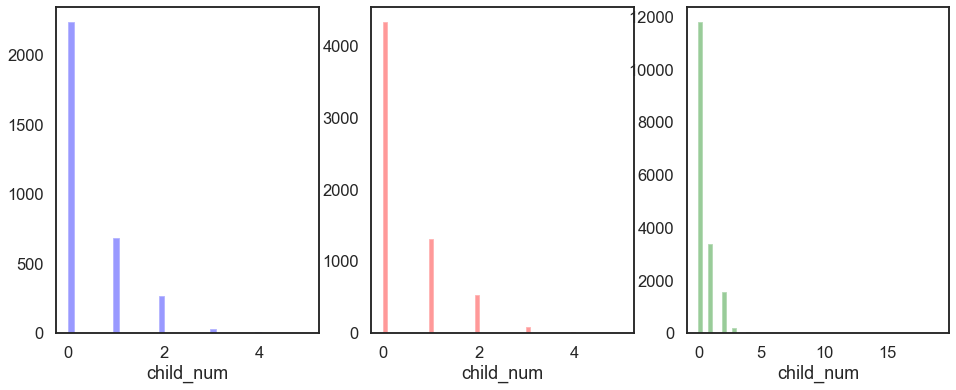

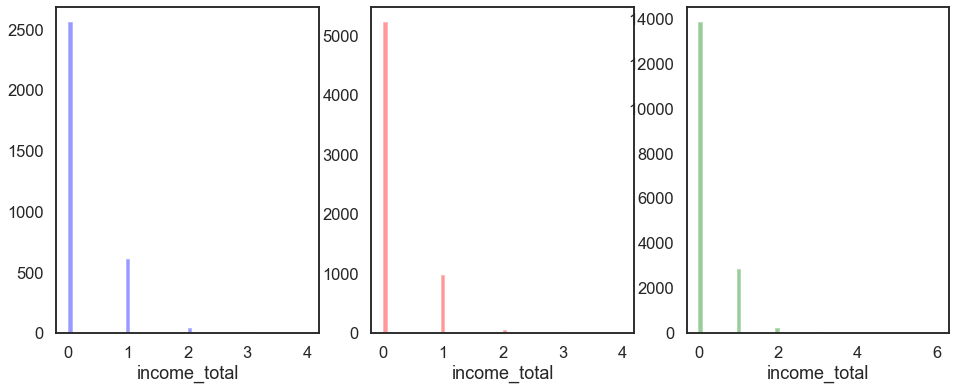

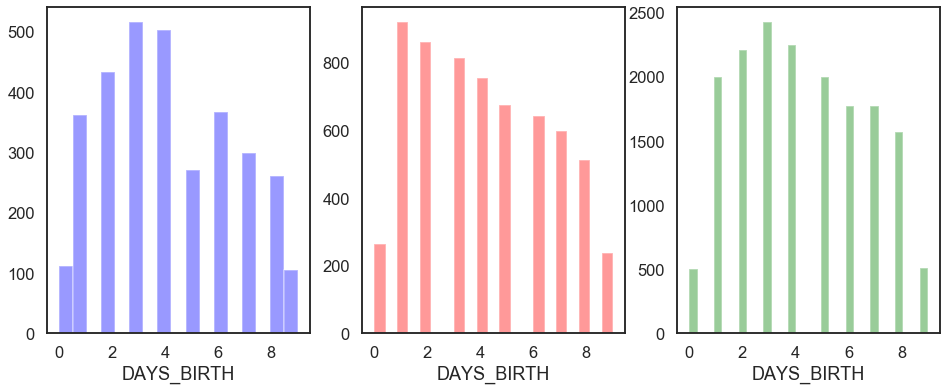

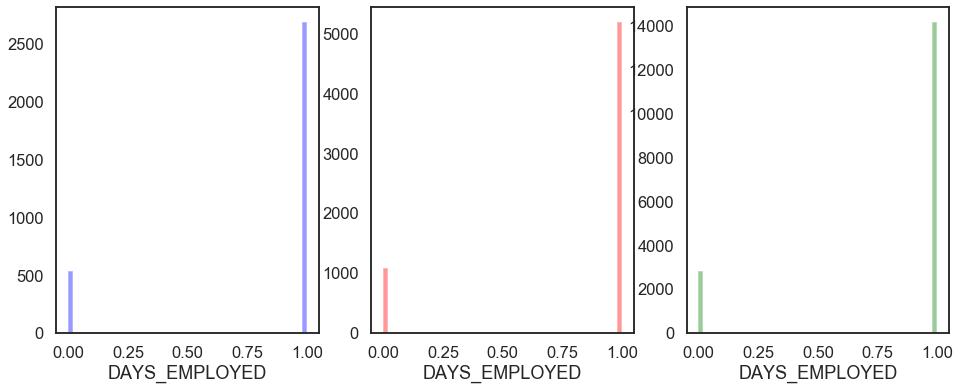

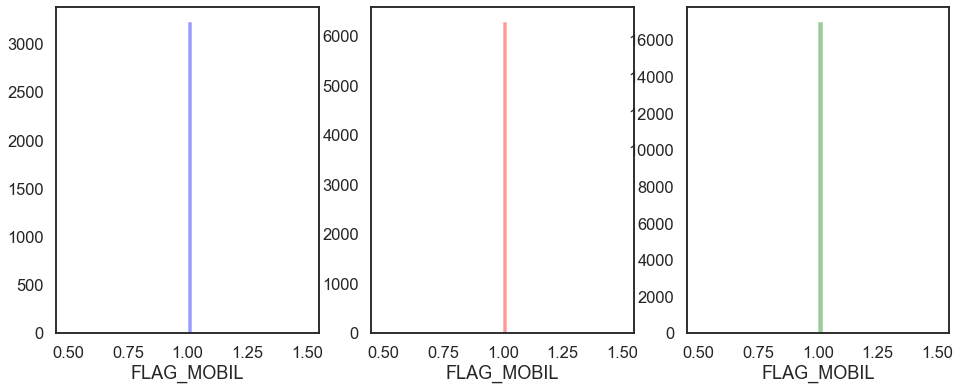

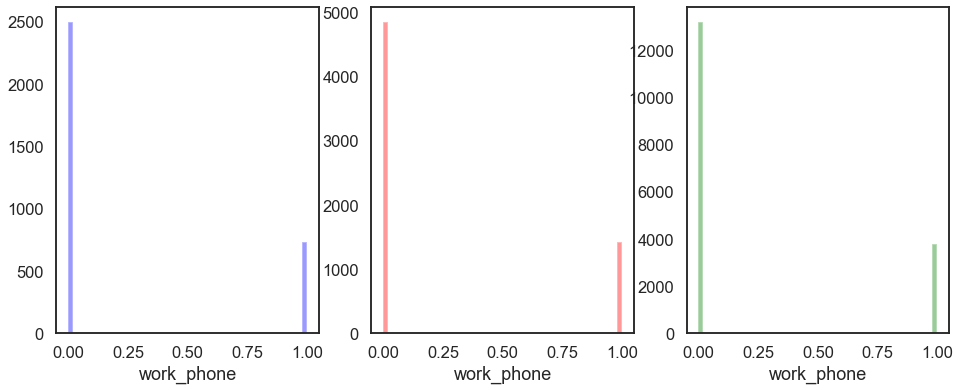

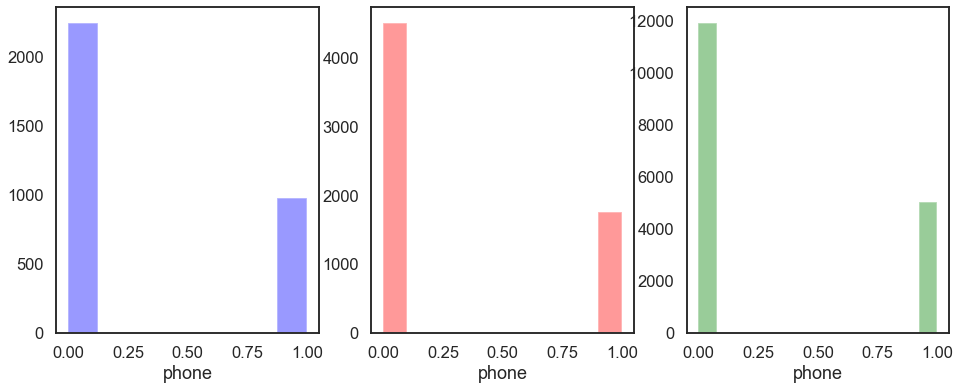

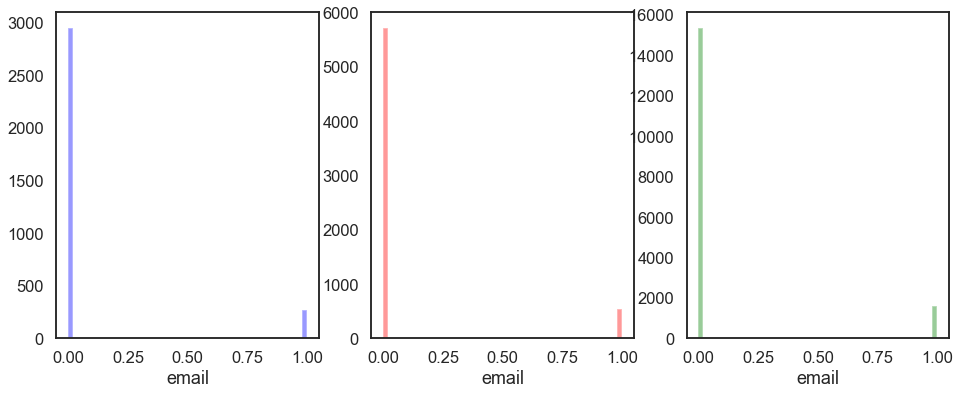

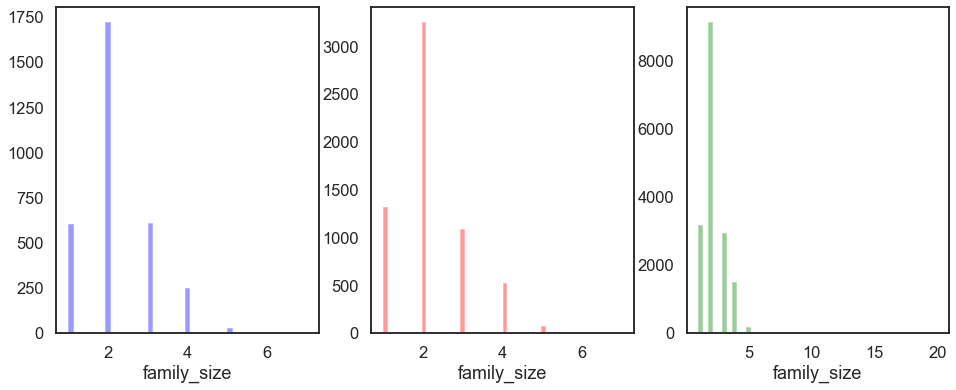

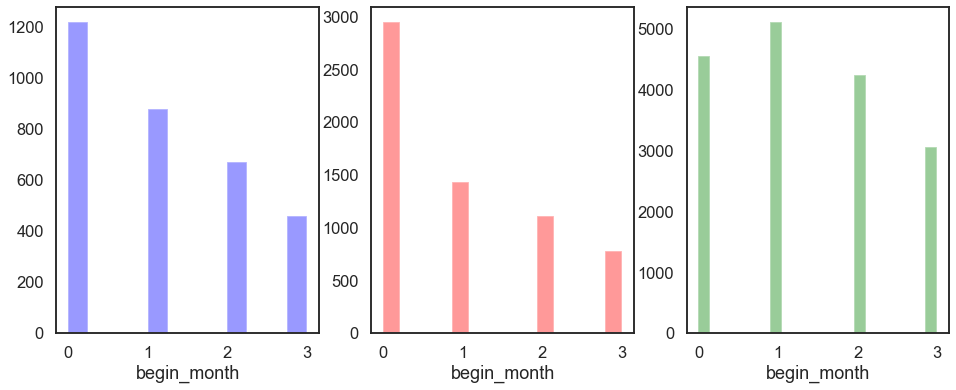

In [106]:
show_hist_by_target(train, num_columns)

In [104]:
num_columns = train.dtypes[train.dtypes != 'object'].index.tolist()

In [105]:
num_columns.remove('credit')

#### Object 값처리하기 factorization이랑 뭐하나 있었는 것 같은데.. 팩토리제이션이 더 편해보임
팩터화 되는 애들
- ['gender','car', 'reality', 'income_type', 'edu_type', 'family_type',  'house_type'] 

In [15]:
object_columns = train.dtypes[train.dtypes == 'object'].index.tolist()
object_columns
for column in object_columns:
    apps[column] = pd.factorize(apps[column])[0]

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type']

# plot 특이사항
* 읽을떄 컬럼잘보고 생각! --> 어쩔수가없는 것같음
* 성별--> 차이 없어보임ㅇ
* car --> 의외로 별 차이 없어보이긴 함 그래도 확실히 2에서는 차있을때 비중이 높긴함 완전 무의미는 X
* reality --> 이거는 의외로 집이 없어도 신용도 높은 비중이 좀 있음 활용은 car와 마찬가지로 그냥 카테고리만
* income_type --> 학생은 조금 극단치?가 아닌가 싶기도함--> 신용이 놆긴함
* --> 신용 1에서 구성이 다른 것이랑  좀 다른 것 같아서 신용평균치로 연산하는 것도 괜찮은 것 같음
* edu_type -->.큰차이가 보이진 않아서 그냥 카테고리컬 정도로 활용하면 좋을 듯 
* family_type --> 사실 이것도 큰차이가 보이진않음 음... 이런것들을 묶어서 따로 그룹바이해서 기초통계내는 것을 함수를 하나 만들어야겠음.
* house_type --> 이것도 잘

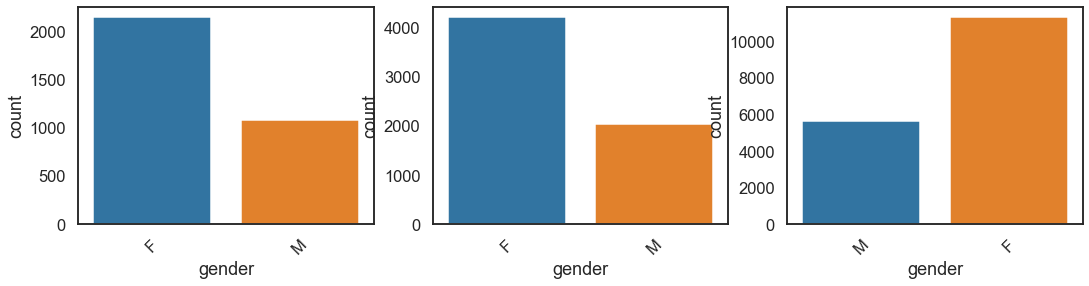

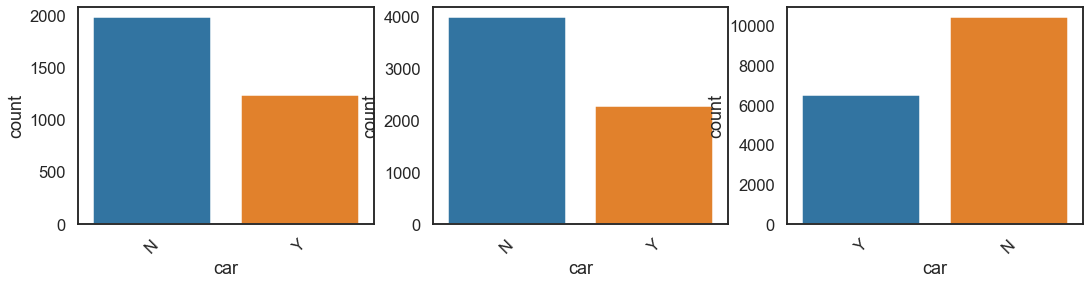

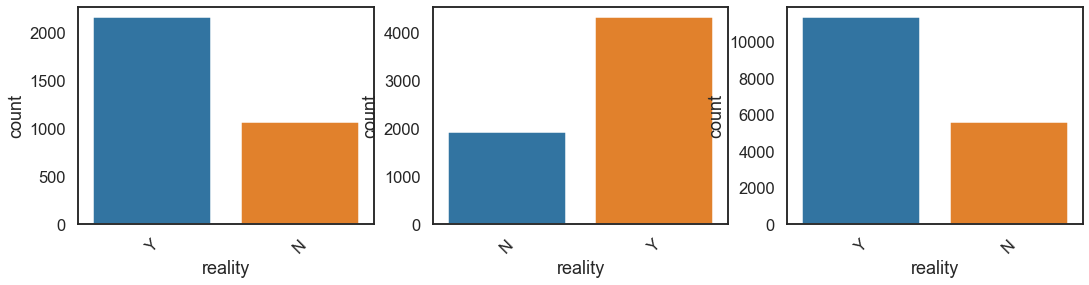

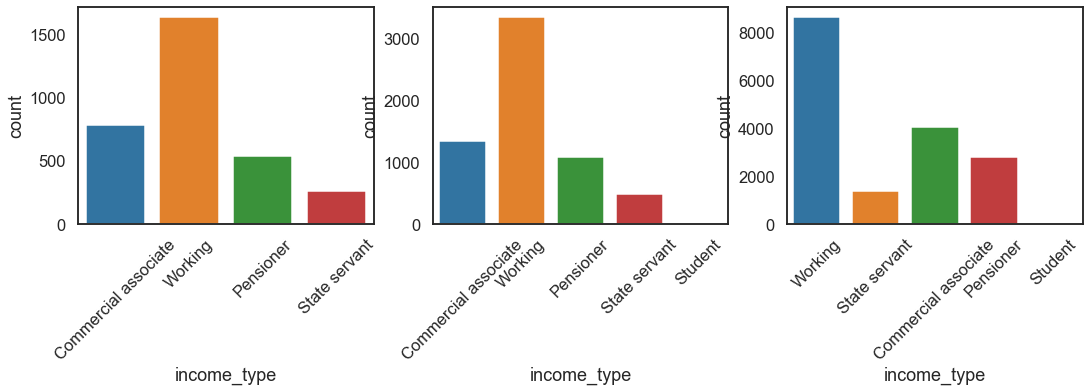

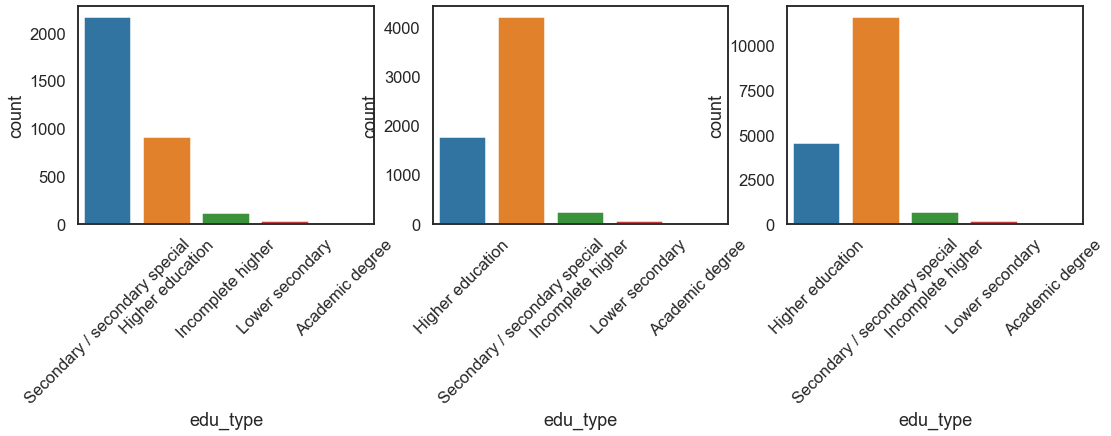

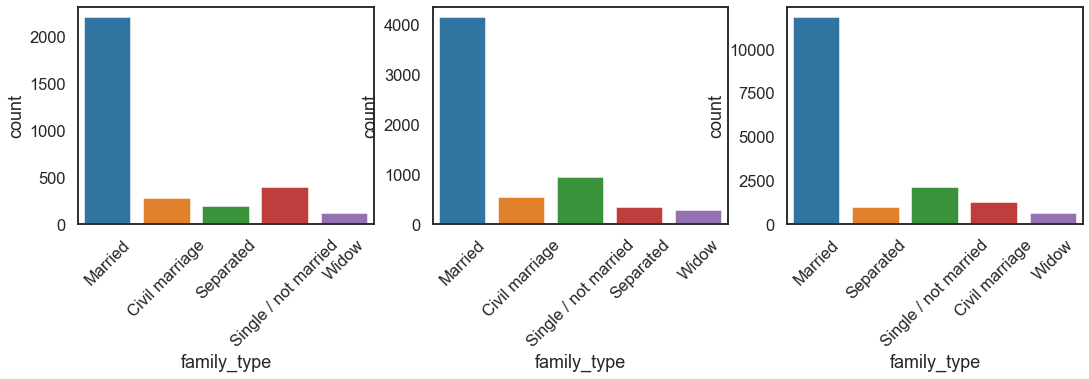

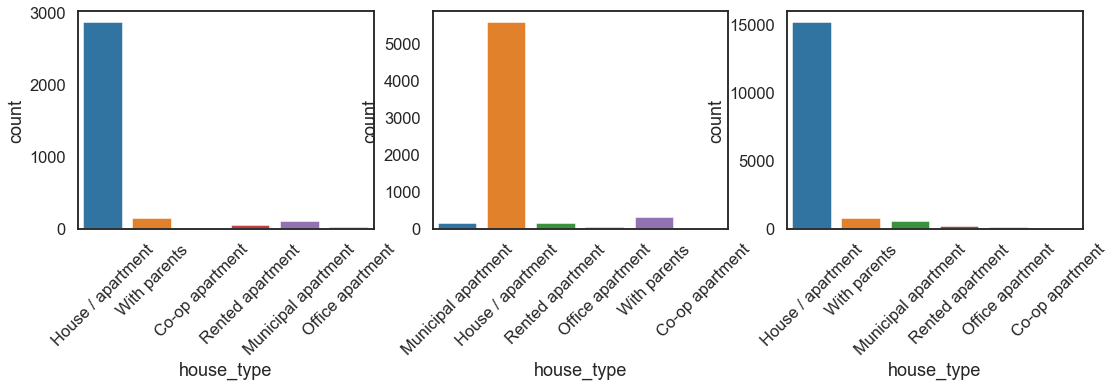

In [26]:
show_count_by_target(train, object_columns)

# corr 특이사항 --> 다중회귀는... 음.. 귀찮으니 좀 고려
* 이게 의미가 있나 싶은데 의외로 email이 크게 영향을 미침 --> 일하는 사람이 이메일을 쓰니깐 그럴까
* childnum은 크게 의미가 없는거 보니깐 앞에서까지 고려했을때 극단치 제거하는게 좋을 것같음
* income_total --> 의외로 의미가 없는 것일까 이게 의미가 없을 수가 있나 전처리과정을 다시 짚어보기
* Days_birth --> 중요한 거 맞는 것 같음 --> 평균치로 환산해서 써는게 좋을 것같음
* Day_employed --> 음.. 이것도 중요한 것 같은데 아 이거는 다시 전처리 해야하는 것 맞음
* family_size --> 일단 극단치 제거하고 다시 생각 childnum 이랑 영향이 서로 매우큰데 극단치가 같이 있는 것 같음 애가 많은 집에고용일도 길긴김 무슨 의미가 있는 걸까 
* begin_month --> 엄청 중요해보임 -->평준화 시키지 말고 쓰는 것도 괜ㄴ찮아보임 (중요한 데이터니깐 영향이 크도록 일부로 이렇게 하면 가능하지 않을까하는 의문 )

In [30]:
corr = train.corr()

In [115]:
corr

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
child_num,1.000000,0.011343,-0.330687,0.229089,NaN,0.051521,-0.010555,0.016120,0.890530,0.007223,0.004081
income_total,0.011343,1.000000,-0.023274,0.107209,NaN,-0.019213,0.041368,0.081112,0.012105,0.004088,0.000052
DAYS_BIRTH,-0.330687,-0.023274,1.000000,-0.617774,NaN,-0.176604,0.029000,-0.110116,-0.296460,0.056476,0.024891
DAYS_EMPLOYED,0.229089,0.107209,-0.617774,1.000000,NaN,0.241721,0.007078,0.091709,0.223751,0.006257,0.003429
FLAG_MOBIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_phone,0.051521,-0.019213,-0.176604,0.241721,NaN,1.000000,0.310256,-0.031048,0.068705,0.008434,-0.003134
phone,-0.010555,0.041368,0.029000,0.007078,NaN,0.310256,1.000000,0.012494,-0.000132,0.012175,0.003452
email,0.016120,0.081112,-0.110116,0.091709,NaN,-0.031048,0.012494,1.000000,0.016122,-0.004038,0.014812
family_size,0.890530,0.012105,-0.296460,0.223751,NaN,0.068705,-0.000132,0.016122,1.000000,0.021932,0.008227
begin_month,0.007223,0.004088,0.056476,0.006257,NaN,0.008434,0.012175,-0.004038,0.021932,1.000000,0.119054


In [117]:
corr>0.2

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
child_num,True,False,False,True,False,False,False,False,True,False,False
income_total,False,True,False,False,False,False,False,False,False,False,False
DAYS_BIRTH,False,False,True,False,False,False,False,False,False,False,False
DAYS_EMPLOYED,True,False,False,True,False,True,False,False,True,False,False
FLAG_MOBIL,False,False,False,False,False,False,False,False,False,False,False
work_phone,False,False,False,True,False,True,True,False,False,False,False
phone,False,False,False,False,False,True,True,False,False,False,False
email,False,False,False,False,False,False,False,True,False,False,False
family_size,True,False,False,True,False,False,False,False,True,False,False
begin_month,False,False,False,False,False,False,False,False,False,True,False


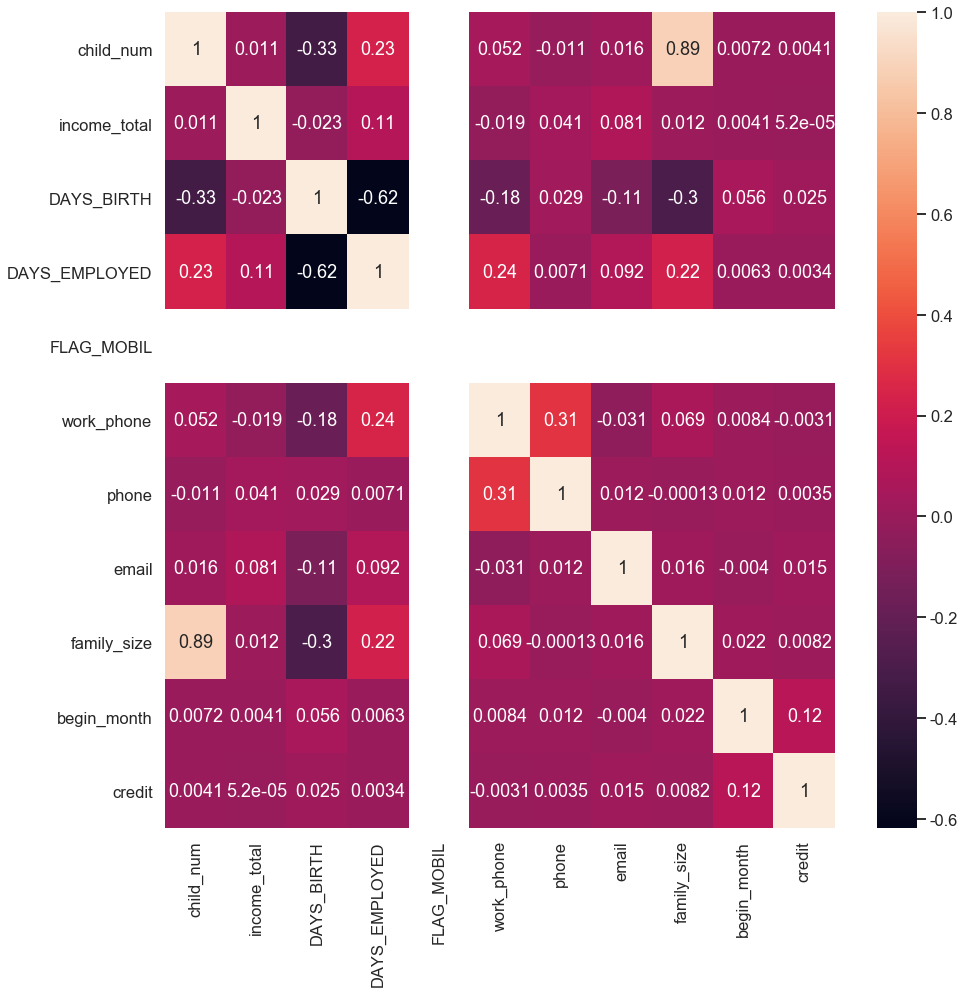

In [33]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True)

# LGBM은 피쳐중요도 볼 수 있는 함수가 있어서 이렇게 활용하는 것도 좋을 듯함

In [ ]:
# 이걸로 대충 훈련시켜보면서 피처 중요한 거 골라보는 것도 좋을 듯  ㅇㅋ
from lightgbm import plot_importance
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

# 이거하기전에 valid_set을 만들어야함 train_tset_split
clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
eval_metric= 'auc', verbose= 100, early_stopping_rounds= 50)
plot_importance(clf, figsize=(16, 32))
